# 02456 2021 Project: Insect classification

- Important! The code can not run unless FaunaPhotonics has agreed for one to have access to their data, database, and code. However, we have run this notebook and saved the outputs for inspection.

## Datasets
Data is provided by FaunaPhotonics and can not be shared, as it is considered owned by the company and confidential.

## References
The python module `evex_scout` imported in labelled_data.generate_data is owned by FaunaPhotonics. The code is used to collect the start and end times of individual insect events from a raw data file. A module named `fpmodules` is used to collect data from a database, which is also owned by FaunaPhotonics. The database consists of labels of whether the extracted events from the raw data file is insect or not. All resources from Faunaphotonics is only used for creating labelled datasets.

The `EarlyStopping` class from machine_learning.early_stopping is from https://github.com/Bjarten/early-stopping-pytorch.

All other code in this repository is made by Freja Thoresen (S213769), Pascal Dufour (S011602), Nikolaj Sheller (C971666).

## Code
The labelled_data folder contains all code to create labelled data files. The file to run the code is make_data.py.
The machine_learning folder contains the model definition and training and validation loops, plus some other helper functions.


In [1]:
from machine_learning.make_model import *
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
wandb.init(project="dtu-course", entity="freja-thoresen")

wandb: Currently logged in as: freja-thoresen (use `wandb login --relogin` to force relogin)


## Set configuration

In [2]:
learning_rate = 0.0002
sequence_length = 10
input_size = 1 # number of features
no_batches = 100
num_classes = 1 # number of output classes

lstm_dropbout = 0.2
linear_dropout = 0.2
lstm_hidden_size = 40 # number of features in hidden state
linear_hidden_size = 60 # number of features in hidden state
num_layers = 2 # number of stacked lstm layers

no_files = 300 # no. data files
epochs = 300 # 1000 epochs

wandb.config = {
    "learning_rate": learning_rate,
    "sequence_length": sequence_length,
    "epochs": epochs,
    "input_size": input_size,
    "lstm_hidden_size": lstm_hidden_size,
    "linear_hidden_size": linear_hidden_size,
    "num_layers": num_layers,
    "no_batches": no_batches,
    "no_files": no_files,
    "lstm_dropbout": lstm_dropbout,
    "linear_dropout": linear_dropout,
    "num_classes": num_classes,
    "input_size": input_size
}

### Define model from configuration

In [3]:
config = Config(wandb.config)
lstm, criterion, optimizer = make_model(config)

## Train model

In [4]:
X_test, y_test = train_model(lstm, criterion, optimizer, config, verbose=1)

training files 240
validation files 30
test files 30
Epoch: 0, training loss: 0.32544, validation loss: 0.67599, training acc: 0.89303, , validation acc: 0.84161
Validation loss decreased (inf --> 0.675991).
Validation loss decreased (0.675991 --> 0.267963).
Validation loss decreased (0.267963 --> 0.251339).
Validation loss decreased (0.251339 --> 0.210895).
Validation loss decreased (0.210895 --> 0.203141).
Epoch: 5, training loss: 0.18690, validation loss: 0.19502, training acc: 0.94489, , validation acc: 0.94599
Validation loss decreased (0.203141 --> 0.195022).
EarlyStopping counter: 1 out of 10
Validation loss decreased (0.195022 --> 0.188100).
Validation loss decreased (0.188100 --> 0.181680).
Validation loss decreased (0.181680 --> 0.180434).
Epoch: 10, training loss: 0.16469, validation loss: 0.18105, training acc: 0.95086, , validation acc: 0.95135
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 

## Inspect model with test data
### Calculate test accuracy
10 % of the full dataset is used to calculate the accuracy of the model. These 10 % has not been used prior in the training or validation of the model.

In [5]:
test_gen = data_generator(X_test, y_test, sequence_length=10)
test_loss=0
test_correct=0
test_all=0
for _ in range(len(X_test)):
  i_batch = 0
  data, labels = test_gen.__next__()
  data = get_variable(data)
  labels = get_variable(labels)

  while data.shape[0] > i_batch + config.no_batches:
    batch_data = Variable(data[i_batch:(i_batch + config.no_batches)])
    batch_labels = Variable(labels[(i_batch * config.sequence_length):(i_batch + config.no_batches) * config.sequence_length])

    lstm.eval()
    outputs = lstm.forward(batch_data)  # forward pass
    loss = criterion(outputs, batch_labels)
    test_loss += loss.item()

    test_correct += (evaluate_result(outputs) == batch_labels).float().sum()
    test_all += len(batch_labels)
    i_batch += no_batches

test_acc = test_correct / float(test_all)
print('test accuracy', np.around(test_acc.item(), decimals=4))

test accuracy 0.9405


### Example of prediction

In [6]:
test_gen = data_generator(X_test, y_test, sequence_length=config.sequence_length)
data, labels = test_gen.__next__()
train_predict = lstm(data)#forward pass
data_predict = train_predict.data.cpu().numpy() #numpy conversion

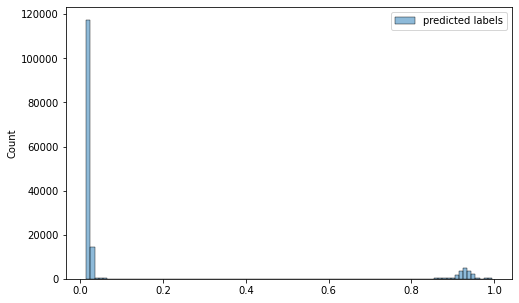

In [7]:
plt.figure(figsize=(8,5))
sns.histplot(data_predict, binwidth=0.01,label='predicted labels')
plt.legend()
plt.show()

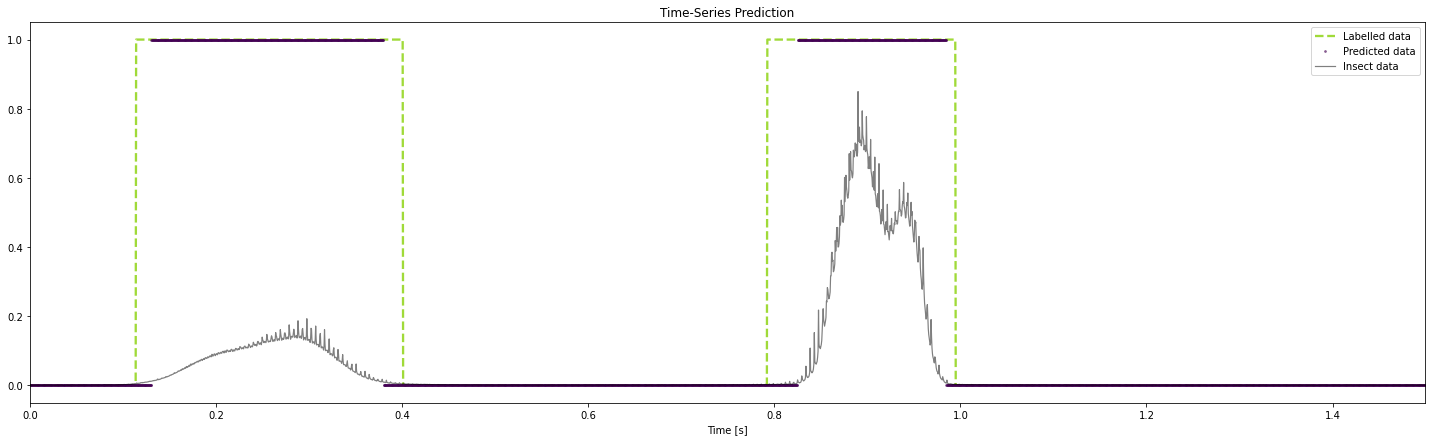

In [8]:
predicted_labels = np.zeros_like(data_predict)
predicted_labels[data_predict > 0.5] = 1
predicted_labels[data_predict < 0.5] = 0

cmap = mpl.cm.get_cmap('viridis', 8)
c1 = mpl.colors.rgb2hex(cmap(6)[:3])
c2 = mpl.colors.rgb2hex(cmap(0)[:3])

# range selection of data (otherwise very long)
x1 = 5000
x2 = 8000

data_plot = data.detach().numpy().flatten()

z = np.linspace(x1,x2-1,x2-x1)
z = (z - x1)/2000
plt.figure(figsize=(25,7)) #plotting

plt.plot(z, labels[x1:x2,:], label='Labelled data', ls='--', c=c1, linewidth=2.3) #actual plot
plt.errorbar(z, predicted_labels[x1:x2,:], label='Predicted data', fmt='o', markersize=1.8, c=c2,alpha=0.5) #predicted plot
plt.title('Time-Series Prediction')
plt.errorbar(z, data_plot[x1:x2] - data_plot[x1], label='Insect data', fmt='-',c='black', alpha=0.5, linewidth=1.2) #predicted plot

plt.gca().set_xlim([0,z[-1]])

plt.gca().set_xlabel('Time [s]')
plt.legend(loc='upper right')
plt.show()